In [2]:
import networkx as nx
import pandas as pd
import pickle
import collections
import matplotlib.pyplot as plt
import numpy as np
import scipy as sc
from sklearn.metrics import roc_curve, auc

In [3]:
G = nx.read_edgelist("data/modified_giant.csv")
E = nx.read_edgelist("data/missing_edges.csv")
with open("data/modified_giant.csv_louvain_1.0.pkl", "rb") as f:
    L = pickle.load(f)

In [4]:
# len(L)
# np.unique(list(L.values())).size

In [5]:
# A = nx.adjacency_matrix(G)

In [6]:
# A3 = np.linalg.matrix_power(A.todense(), 3)

In [7]:
# L = sc.sparse.csgraph.laplacian(A).todense()

In [8]:
# #OK, let's try the matrix forest stuff
# S = np.linalg.inv(L + np.identity(G.number_of_nodes()))

In [9]:
# np.allclose(L, L.getH())

In [10]:
# L_plus = np.linalg.pinv(L)  # the Moore-Penrose pseudoinverse, see https://ieeexplore-ieee-org.ezproxy.lib.vt.edu/document/4072747, https://www-sciencedirect-com.ezproxy.lib.vt.edu/science/article/pii/S0378437120300856
# # this will have to be done off of Jupyter -too much mem

In [11]:
# conjac = pd.read_csv("data/modified_giant.csv.connected_jaccard_results.csv")[["source", "destination", "jaccard_coeff"]]
# print(conjac.head())

In [12]:
print(G.number_of_edges())
print(E.number_of_edges())

248594
62148


In [13]:
# avg_conjac = conjac["jaccard_coeff"].values.mean()
# print(avg_conjac)
# conjac.shape

In [14]:
# giant = nx.read_edgelist("data/giant.csv")
# giantnodes = list(giant.nodes())

In [9]:
# from random import sample
# wrong_edges = nx.Graph()
# for i in range(E.number_of_edges()):
#     found = False
#     while found == False:
#         v1, v2 = sample(giantnodes, 2)
#         if giant.has_edge(v1, v2): continue
#         wrong_edges.add_edge(v1, v2)
#         found = True
# nx.write_edgelist(wrong_edges, "data/wrong_edges.csv")
wrong_edges = nx.read_edgelist("data/wrong_edges.csv")

In [10]:
wrongjac = pd.DataFrame(list(nx.jaccard_coefficient(G, list(wrong_edges.edges()))), columns=["source", "destination", "jaccard_coeff"])
print(wrongjac.head())
wrongjac.shape

     source destination  jaccard_coeff
0  C0005540    C0597875            0.0
1  C0005540    C0546535            0.0
2  C0005540    C4489237            0.0
3  C0005540    C0444624            0.0
4  C0005540    C0016169            0.0


(62148, 3)

In [11]:
wrongjac["jaccard_coeff"].values.mean()

0.010509857836423893

In [12]:
missingjac = pd.DataFrame(list(nx.jaccard_coefficient(G, list(E.edges()))), columns=["source", "destination", "jaccard_coeff"])
print(missingjac.head())
print(missingjac.shape)
print(missingjac["jaccard_coeff"].values.mean())

     source destination  jaccard_coeff
0  C0301872    C0015663       0.024194
1  C0301872    C0042742       0.033217
2  C0301872    C0021289       0.049430
3  C0301872    C0079005       0.025862
4  C0301872    C4554665       0.005474
(62148, 3)
0.02538392744600517


In [13]:
missingjac["y_true"] = 1
wrongjac["y_true"] = 0
featuresdf = missingjac.append(wrongjac, ignore_index=True)

In [4]:
# y_true = list([1] * E.number_of_edges())
# y_true.extend(list([0] * wrong_edges.number_of_edges()))
# y_score = list(missingjac["jaccard_coeff"].values)
# y_score.extend(list(wrongjac["jaccard_coeff"].values))
# print(len(y_true), len(y_score))
featuresdf = pd.read_csv("data/neural_network_training_data.csv")

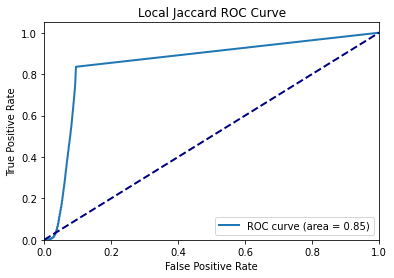

In [7]:
fpr, tpr, _ = roc_curve(featuresdf["y_true"], featuresdf["jaccard_coeff"])
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, # color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Local Jaccard ROC Curve')
plt.legend(loc="lower right")
plt.savefig("fig/local_jaccard_roc.png", format="png")
plt.show()
# plt.savefig("fig/local_jaccard_roc.png", format="png")

In [43]:
len(fpr)

9320

0.16441397953272832


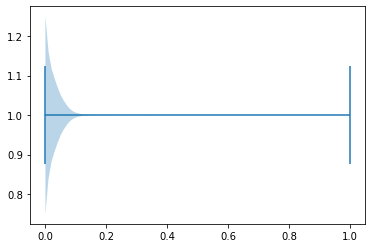

In [14]:
print(np.count_nonzero(missingjac["jaccard_coeff"].values == 0) / missingjac["jaccard_coeff"].values.size)
plt.figure()
plt.violinplot(missingjac["jaccard_coeff"].values, vert=False)  # , bins=20, log=True)
plt.savefig("fig/local_jaccard_violin.png", format="png")

0.9050975091716548


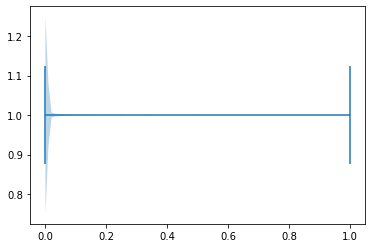

In [15]:
print(np.count_nonzero(wrongjac["jaccard_coeff"].values == 0) / wrongjac["jaccard_coeff"].values.size)
plt.figure()
plt.violinplot(wrongjac["jaccard_coeff"].values, vert=False)
plt.savefig("fig/local_jaccard_ghost_edges_violin.png", format="png")
# plt.plot(sorted(wrongjac(jaccard_co)))

In [24]:
# # generate 1-hop neighborhood graph
# onehopG = G.copy()
# for vertex in list(G.nodes()):
#     for n in nx.neighbors(G, vertex):
#         for dst in nx.neighbors(G, n):
#             if onehopG.has_edge(vertex, dst): continue
#             onehopG.add_edge(vertex, dst)
# print(onehopG.number_of_edges())
# nx.write_edgelist(onehopG, "data/modified_giant_one_hop_neighborhood.edgelist")

110921486


In [25]:
# featuresdf["1hop_jaccard_coeff"] = featuresdf.apply(lambda row: list(nx.jaccard_coefficient(onehopG, [(row["source"], row["destination"])]))[0][2], axis=1)  # nx.jaccard_coefficient(onehopG, row["source"], row["destination"]))

In [27]:
# featuresdf.head()
# featuresdf.to_csv("data/features_w_1hop_jaccard.csv")

In [26]:
# generate 2-hop neighborhood graph
twohopG = nx.read_edgelist("data/modified_giant_one_hop_neighborhood.edgelist")
for vertex in list(G.nodes()):
    for n in nx.neighbors(onehopG, vertex):
        for dst in nx.neighbors(G, n):
            if twohopG.has_edge(vertex, dst): continue
            twohopG.add_edge(vertex, dst)
print(twohopG.number_of_edges())
nx.write_edgelist(twohopG, "data/modified_giant_two_hop_neighborhood.edgelist")

NameError: name 'onehopG' is not defined

In [ ]:
featuresdf["2hop_jaccard_coeff"] = featuresdf.apply(lambda row: nx.jaccard_coefficient(twohopG, row["source"], row["destination"]))

In [56]:
# missing2hopjac = pd.DataFrame(list(nx.jaccard_coefficient(twohopG, list(E.edges()))), columns=["source", "destination", "jaccard_coeff"])
# # print(missing2hopjacjac.head())
# print(missing2hopjac.shape)
# print(missing2hopjac["jaccard_coeff"].values.mean())
# wrong2hopjac = pd.DataFrame(list(nx.jaccard_coefficient(twohopG, list(wrong_edges.edges()))), columns=["source", "destination", "jaccard_coeff"])
# print(wrong2hopjac.shape)
# print(wrong2hopjac["jaccard_coeff"].values.mean())

(62148, 3)
0.05841507035170085
(62148, 3)
0.1229561577252855


0.018005406449121453
0.379143335264208


Text(0.5, 1.0, 'Wrong Edges 2 Hop Jaccard')

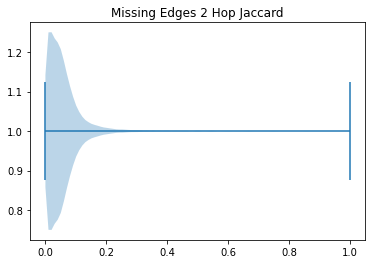

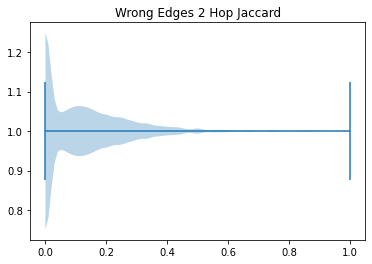

In [60]:
# print(np.count_nonzero(missing2hopjac["jaccard_coeff"].values == 0) / missing2hopjac["jaccard_coeff"].values.size)
# plt.figure()
# plt.violinplot(missing2hopjac["jaccard_coeff"].values, vert=False)  # , bins=20, log=True)
# plt.title("Missing Edges 2 Hop Jaccard")
# print(np.count_nonzero(wrong2hopjac["jaccard_coeff"].values == 0) / wrong2hopjac["jaccard_coeff"].values.size)
# plt.figure()
# plt.violinplot(wrong2hopjac["jaccard_coeff"].values, vert=False)  # , bins=20, log=True)
# plt.title("Wrong Edges 2 Hop Jaccard")
# plt.savefig("")

In [18]:
featuresdf = pd.read_csv("data/neural_network_training_data.csv")

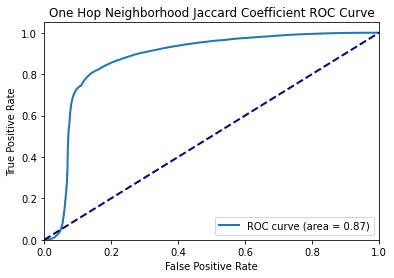

In [19]:
# twohopy_true = list([1] * E.number_of_edges())
# twohopy_true.extend(list([0] * wrong_edges.number_of_edges()))
# twohopy_score = list(missing2hopjac["jaccard_coeff"].values)
# twohopy_score.extend(list(wrong2hopjac["jaccard_coeff"].values))
# print(len(twohopy_true), len(twohopy_score))
onehopfpr, onehoptpr, _ = roc_curve(featuresdf["y_true"], featuresdf["1hop_jaccard_coeff"])
roc_auc = auc(onehopfpr, onehoptpr)
plt.figure()
lw = 2
plt.plot(onehopfpr, onehoptpr, # color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('One Hop Neighborhood Jaccard Coefficient ROC Curve')
plt.legend(loc="lower right")
plt.savefig("fig/1hop_jaccard_roc.png", format="png")
plt.show()

In [20]:
with open("data/modified_giant.csv_louvain_1.0.pkl", "rb") as f:
    L = pickle.load(f)

In [30]:
# why is deployment on supercomputers important?
# what we deployed?
# evaluation criteria

In [21]:
import pickle
num_same_comm = 0
for src, dst in E.edges():
    if L[src] == L[dst]:
        num_same_comm += 1
print("Percent missing in same community = ", float(num_same_comm) / float(E.number_of_edges()) * 100)
num_same_comm = 0
for src, dst in wrong_edges.edges():
    if L[src] == L[dst]:
        num_same_comm += 1
print("Percent wrong in same community = ", float(num_same_comm) / float(E.number_of_edges()) * 100)

Percent missing in same community =  53.24386947287121
Percent wrong in same community =  21.218703739460643


In [22]:
comms = np.unique(list(L.values()))
ncomms = np.max(comms) + 1
blockmodel = np.zeros((ncomms, ncomms), dtype=np.int32)
for src, dst in G.edges():
    blockmodel[L[src],L[dst]] += 1
blockmodel = blockmodel / blockmodel.sum()

In [23]:
print(blockmodel.mean(), np.max(blockmodel))

1.2311480455524777e-05 0.22753968317819417


In [13]:
# bmdf = pd.DataFrame()
# for s, d in E.edges():
#     src = L[s]
#     dst = L[d]
#     bmdf = bmdf.append({"source": src, "destination": dst, "bm_p": blockmodel[src, dst], "y_true": 1}, ignore_index=True)
# for s, d in wrong_edges.edges():
#     src = L[s]
#     dst = L[d]
#     bmdf = bmdf.append({"source": src, "destination": dst, "bm_p": blockmodel[src, dst], "y_true": 0}, ignore_index=True)
# # missingbm = pd.DataFrame(blockmodel[E_edges], columns=["source", "destination", "bm_p"])
# # print(missing2hopjacjac.head())
# print(missingbm.shape)
# print(bmdf[bmdf["y_true"] == 1]["bm_p"].values.mean(), bmdf[bmdf["y_true"] == 0]["bm_p"].values.mean())
# # wrongbm = pd.DataFrame(blockmodel[list(wrong_edges.edges())], columns=["source", "destination", "bm_p"])
# # print(wrongbm.shape)
# # print(wrongbm["bm_p"].values.mean())

(62148, 3)
0.11966462531314603 0.05494889303656029


In [34]:
# featuresdf["bm_edge_probability"] = featuresdf.apply(lambda row: blockmodel[L[row["source"]], L[row["destination"]]], axis=1)
# print(featuresdf.head())
# featuresdf.to_csv("data/neural_network_training_data.csv")

     source destination  jaccard_coeff  y_true  1hop_jaccard_coeff  \
0  C0301872    C0015663       0.024194       1            0.643389   
1  C0301872    C0042742       0.033217       1            0.629564   
2  C0301872    C0021289       0.049430       1            0.458920   
3  C0301872    C0079005       0.025862       1            0.220696   
4  C0301872    C4554665       0.005474       1            0.476631   

   bm_edge_probability  
0             0.033319  
1             0.214699  
2             0.033319  
3             0.214699  
4             0.033319  


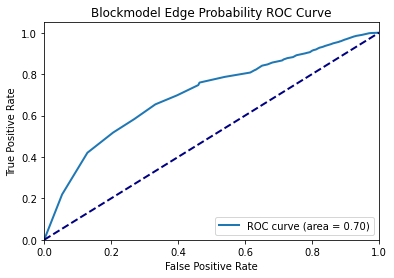

In [24]:
# twohopy_true = list([1] * E.number_of_edges())
# twohopy_true.extend(list([0] * wrong_edges.number_of_edges()))
# twohopy_score = list(missing2hopjac["jaccard_coeff"].values)
# twohopy_score.extend(list(wrong2hopjac["jaccard_coeff"].values))
# print(len(twohopy_true), len(twohopy_score))
bmfpr, bmtpr, _ = roc_curve(featuresdf["y_true"].values, featuresdf["bm_edge_probability"].values)
roc_auc = auc(bmfpr, bmtpr)
plt.figure()
lw = 2
plt.plot(bmfpr, bmtpr, # color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Blockmodel Edge Probability ROC Curve')
plt.legend(loc="lower right")
plt.savefig("fig/bm_edge_prob_roc.png", format="png")
plt.show()

In [ ]:
src dst J1 + J2 + E 1/0 <-- train, valid, test

In [44]:
# Full graph -> giant component -> delete 20% of the edges, sample same number of nonexistent edges -> partial graph, validation dataset. 

SyntaxError: invalid syntax (2740781241.py, line 1)

In [45]:
# for every edge in validation:
#     (partial graph).jaccard(edge)

In [ ]:
# import pandas as pd

# df = pd.read_csv("data/neural_network_training_data.csv")
# data = df[["jaccard_coeff", "1hop_jaccard_coeff", "bm_edge_probability", "y_true"]].values

In [56]:
featuresdf["simple_comb"] = featuresdf["jaccard_coeff"] + featuresdf["1hop_jaccard_coeff"] + featuresdf["bm_edge_probability"]
featuresdf["simple_comb2"] = (featuresdf["jaccard_coeff"] + featuresdf["1hop_jaccard_coeff"]) * featuresdf["bm_edge_probability"]

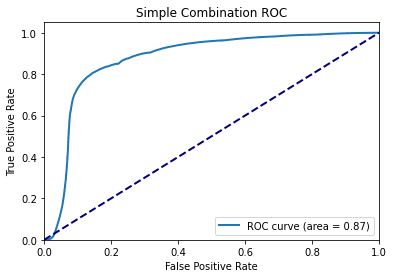

In [58]:
comb1fpr, comb1tpr, _ = roc_curve(featuresdf["y_true"].values, featuresdf["simple_comb"].values)
roc_auc = auc(comb1fpr, comb1tpr)
plt.figure()
lw = 2
plt.plot(comb1fpr, comb1tpr, # color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Simple Combination ROC')
plt.legend(loc="lower right")
plt.show()

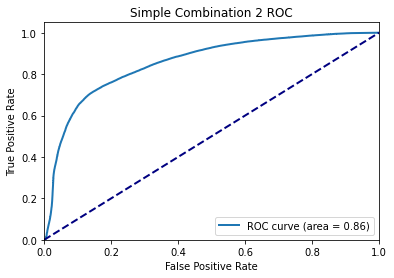

In [69]:
comb2fpr, comb2tpr, _ = roc_curve(featuresdf["y_true"].values, featuresdf["simple_comb2"].values)
roc_auc = auc(comb2fpr, comb2tpr)
plt.figure()
lw = 2
plt.plot(comb2fpr, comb2tpr, # color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Simple Combination 2 ROC')
plt.legend(loc="lower right")
plt.show()

In [61]:
from sklearn.preprocessing import normalize
sffeatures = featuresdf.copy()
sffeatures["jaccard_coeff"] = normalize(sffeatures["jaccard_coeff"].values.reshape((-1, 1)))
sffeatures["1hop_jaccard_coeff"] = normalize(sffeatures["1hop_jaccard_coeff"].values.reshape((-1, 1)))
sffeatures["bm_edge_probability"] = normalize(sffeatures["bm_edge_probability"].values.reshape((-1, 1)))

In [62]:
sffeatures.head()

,source,destination,jaccard_coeff,y_true,1hop_jaccard_coeff,bm_edge_probability,simple_comb,simple_comb2
0,C0301872,C0015663,1.0,1,1.0,1.0,0.700902,0.022243
1,C0301872,C0042742,1.0,1,1.0,1.0,0.877481,0.142299
2,C0301872,C0021289,1.0,1,1.0,1.0,0.541669,0.016938
3,C0301872,C0079005,1.0,1,1.0,1.0,0.461257,0.052936
4,C0301872,C4554665,1.0,1,1.0,1.0,0.515425,0.016063


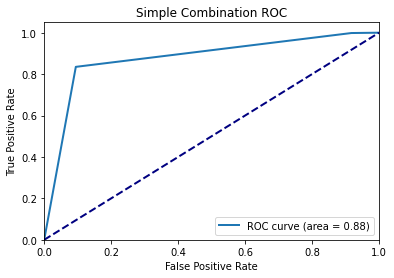

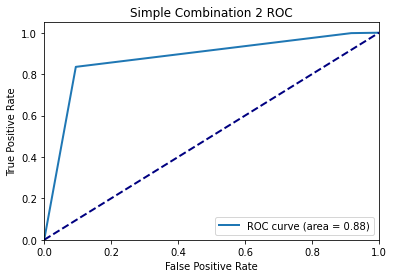

In [70]:
sffeatures["simple_comb"] = sffeatures["jaccard_coeff"] + sffeatures["1hop_jaccard_coeff"] + sffeatures["bm_edge_probability"]
sffeatures["simple_comb2"] = (sffeatures["jaccard_coeff"] + sffeatures["1hop_jaccard_coeff"]) * sffeatures["bm_edge_probability"]
comb1fpr, comb1tpr, _ = roc_curve(sffeatures["y_true"].values, sffeatures["simple_comb"].values)
roc_auc = auc(comb1fpr, comb1tpr)
plt.figure()
lw = 2
plt.plot(comb1fpr, comb1tpr, # color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Simple Combination ROC')
plt.legend(loc="lower right")
plt.show()
comb2fpr, comb2tpr, _ = roc_curve(sffeatures["y_true"].values, sffeatures["simple_comb2"].values)
roc_auc = auc(comb2fpr, comb2tpr)
plt.figure()
lw = 2
plt.plot(comb2fpr, comb2tpr, # color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Simple Combination 2 ROC')
plt.legend(loc="lower right")
plt.show()

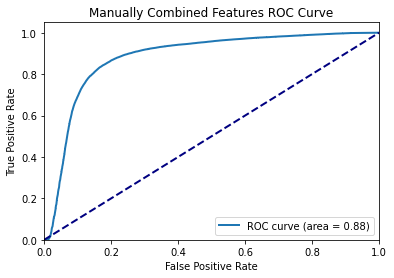

In [25]:
featuresdf["simple_comb3"] = featuresdf["jaccard_coeff"] + (featuresdf["1hop_jaccard_coeff"] * featuresdf["bm_edge_probability"])
comb3fpr, comb3tpr, _ = roc_curve(featuresdf["y_true"].values, featuresdf["simple_comb3"].values)
roc_auc = auc(comb3fpr, comb3tpr)
plt.figure()
lw = 2
plt.plot(comb3fpr, comb3tpr, # color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Manually Combined Features ROC Curve')
plt.legend(loc="lower right")
plt.savefig("fig/manual_feature_combination.png", format="png")
plt.show()